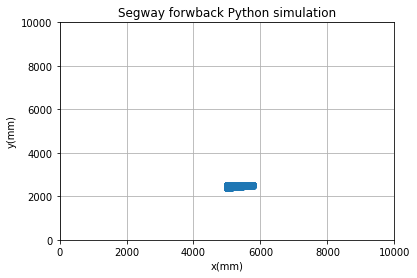

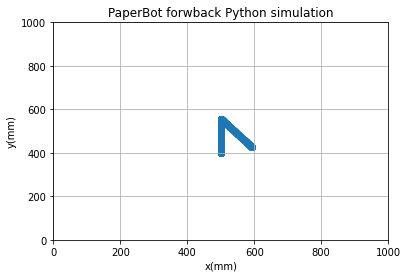

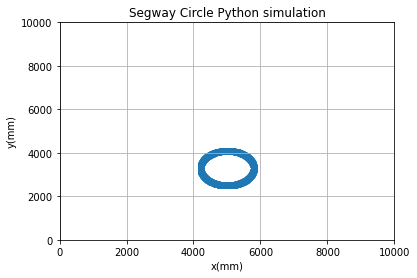

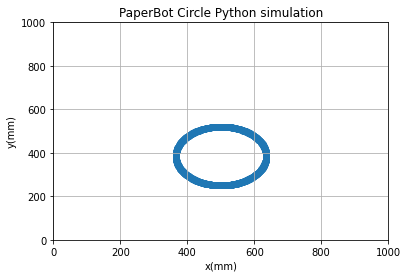

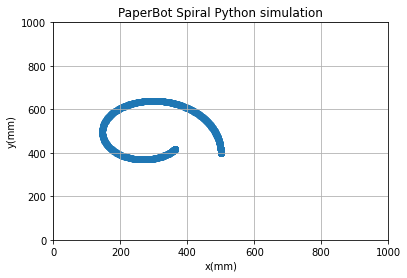

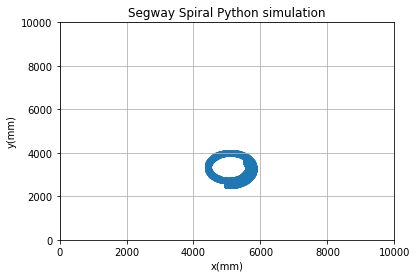

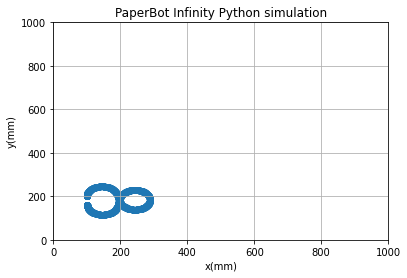

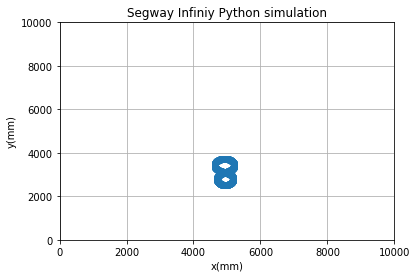

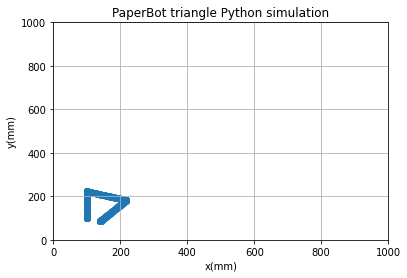

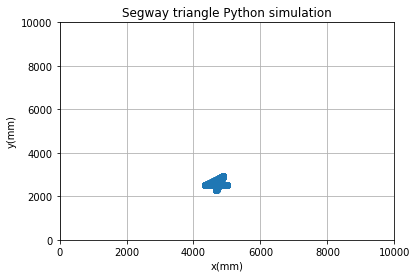

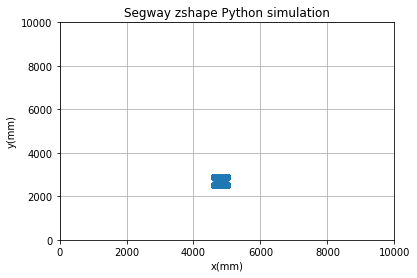

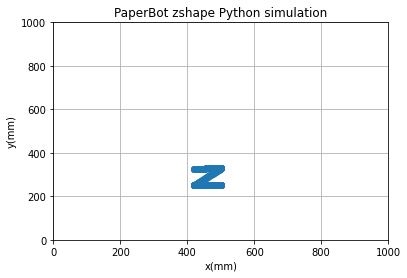

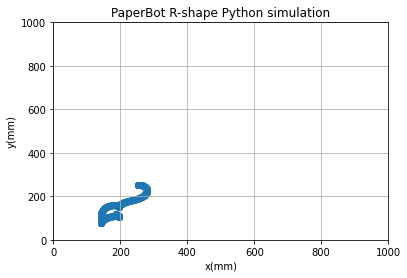

In [1]:
import os
import numpy as np
import math
import matplotlib.pyplot as plt

w_max = 100*2*math.pi/60
ts = 0.01

class Arena:
   
    #constructor
  def __init__(self,size = [1000,1000], init_state = np.zeros(3),robotType = 'Paperbot', dt = 0.01):
    self.size = size
    #state = [x,y,theta(degrees)]
    self.state = init_state
        
    #Time scale
    self.time = dt
        
    #wheel angular velocities
    self.wR = 0.0
    self.wL = 0.0
        
    #history for plotting
    self.x_hist = []
    self.y_hist = []
    self.d = 50.0  #diameter of wheel (mm)
    self.W = 90.0 #width of robot (mm)
    self.R = self.d/2 #radius of wheel  
    if (robotType == 'Segway'):
      self.d = 502.0 #diameter of wheel (mm)
      self.W = 530.0  #width of robot (mm)
      self.R = self.d/2 #radius of wheel
      self.size = [10000,10000]
        
  def pwmToAngular(self,pwmValue = 0.0):
    if (pwmValue < 0.05 and pwmValue > -0.05):
      return 0
        
    elif (pwmValue > 0.3):
      return (0.5*(pwmValue-0.3)+0.3)*w_max
        
    elif (pwmValue < -0.3):
      return (0.5*(pwmValue+0.3)-0.3)*w_max
        
    else:
      return pwmValue*w_max
    
  def state_update(self, i = np.zeros(2),angular=False):
        
    self.x_hist.append(self.state[0])
    self.y_hist.append(self.state[1])
        
    #inputs
    self.wL = self.pwmToAngular(i[1])
    self.wR = self.pwmToAngular(i[0])
        
    if angular == True:
      self.wL = i[1]
      self.wR = i[0]
        
    #current state
    x = self.state[0]
    y = self.state[1]
    theta = self.state[2]*math.pi/180
        
    #Time Scale
    T = self.time
    self.state[0] = x + 0.5*self.R*T*self.wR*math.cos(theta) + 0.5*self.R*T*self.wL*math.cos(theta)
    self.state[1] = y + 0.5*self.R*T*self.wR*math.sin(theta) + 0.5*self.R*T*self.wL*math.sin(theta)
    self.state[2] = ((180/math.pi)*(theta + self.R*T*self.wR/self.W - self.R*T*self.wL/self.W))%360
        
    #check out of bounds
    if (self.state[0] > self.size[0]):
      self.state[0] = self.size[0]

    if (self.state[0] < 0):
      self.state[0] = 0
            
    if (self.state[1] > self.size[1]):
      self.state[1] = self.size[1]
            
    if (self.state[1] < 0):
      self.state[1] = 0
  
        
    
    #Calculate euclidean distance from current state to coord = (x,y)
  def distance(self,coord = [0,0]):
    x_dist = (coord[0] - self.state[0])**2
    y_dist = (coord[1] - self.state[1])**2
    return (x_dist + y_dist)**(.5)
    
    #check if coord = (x,y) is inside the boundries
  def check_in(self,coord = [0,0]):
    if (coord[0] < 0 or coord[0] > self.size[0]):
      return False
    if (coord[1] < 0 or coord[1] > self.size[1]):
      return False
    return True
  
    
    #returns the observation; [df,dr,wc,hx,hy]
  def observation(self):
    #angle in radians
    theta = self.state[2]*math.pi/180
    tf = math.tan(theta)
    tr = math.tan(theta - (math.pi)/2)
    Width = self.size[0];
    Height = self.size[1];
    x0 = self.state[0];
    y0 = self.state[1];
    #df and dr as specified in the doc
    df = -1
    dr = -1
    # Case theta = 0
    if theta == 0:
      df = Width - x0
      dr = y0
    # Case theta = 90 degrees
    elif theta == (math.pi)/2:
      df = Height - y0
      dr = Width - x0
    # Case theta = 180 degrees  
    elif theta == math.pi:
      df = x0
      dr = Height - y0
    #Case theta = 270 degrees
    elif theta == 3*(math.pi)/2:
      df = y0
      dr = x0
    #Case the
    elif theta < math.pi/2:
      y = tf*(Width - x0) + y0
      if self.check_in([Width, y]) == True:
        df = self.distance([Width, y])
      else:
        x = x0 + (Height - y0)/tf
        df = self.distance([x, Height])
        y = tr*(Width - x0) + y0
      if self.check_in([Width, y]) == True:
        dr = self.distance([Width, y])
      else:
        x = x0 - (y0)/tr
        dr = self.distance([x, 0])
                
    elif theta < math.pi:
      y = tf*(0 - x0) + y0
      if self.check_in([0, y]) == True:
        df = self.distance([0, y])
      else:
        x = x0 + (Height - y0)/tf
        df = self.distance([x, Height])
        y = tr*(Width - x0) + y0
      if self.check_in([Width, y]) == True:
        dr = self.distance([Width, y])
      else:
        x = x0 + (Height - y0)/tr
        dr = self.distance([x, Height])
                
    elif theta < 3*math.pi/2:
      y = tf*(0 - x0) + y0
      if self.check_in([0, y]) == True:
        df = self.distance([0, y])
      else:
        x = x0 + (0 - y0)/tf
        df = self.distance([x, 0])
        y = tr*(0 - x0) + y0
      if self.check_in([0, y]) == True:
        dr = self.distance([0, y])
      else:
        x = x0 + (Height - y0)/tr
        dr = self.distance([x, Height])
                
    elif theta < 2*math.pi:
      y = tf*(Width - x0) + y0
      if self.check_in([Width, y]) == True:
        df = self.distance([Width, y])
      else:
        x = x0 + (0 - y0)/tf
        df = self.distance([x, 0])
        y = tr*(0 - x0) + y0
      if self.check_in([0, y]) == True:
        dr = self.distance([0, y])
      else:
        x = x0 - (y0)/tr
        dr = self.distance([x, 0])
                
    # angular rate )
    wC = (self.wR*self.R - self.wL*self.R)/self.W
    
    #magnetic field components
    Hx = math.cos(theta)
    Hy = math.sin(theta)
    return [df,dr,wC,Hx,Hy]
  
  def get_state(self):
    return self.state
    
  

  def interpolate(self,st = 0,et = 1, a1=0 , a2=0):
    w_inputs = []
    ts = self.time
    #linear equation
    m = (a2 - a1)/(et - st)
    t = st
    while t < et:
    #calculate w at time t
      w = m*(t - st) + a1
      w_inputs.append(w)
      t += ts
    return w_inputs
  def interpolate(self,st = 0,et = 1, a1=0 , a2=0):
    w_inputs = []
    ts = self.time
    #linear equation
    m = (a2 - a1)/(et - st)
    t = st
    while t < et:
      #calculate w at time t
      w = m*(t - st) + a1
      w_inputs.append(w)
      t += ts
    return w_inputs
  def simulate(self,table=[]):
    #table[i] = [time[i], inputR[i], inputL[i]] from the CAD JPG
    for i in range(0,len(table)-1):
      R = self.interpolate(table[i][0], table[i + 1][0], table[i][1], table[i + 1][1])
      L = self.interpolate(table[i][0], table[i + 1][0], table[i][2], table[i + 1][2])
      for j in range(0, len(R)):
        wr = R[j]*math.pi/180
        wl = L[j]*math.pi/180
        self.state_update([wr, wl],angular = True)

  def plot_state(self):
    plt.scatter(self.x_hist,self.y_hist)
    plt.xlabel('x(mm)')
    plt.ylabel('y(mm)')
    plt.xlim([0,self.size[0]])
    plt.ylim([0,self.size[1]])
    plt.grid(True)
def main():
  ArenaTest = Arena(init_state = [500,500,0])

  for i in range(0,25):
        #print("State: ")
        #print(ArenaTest.get_state())
        #print("Observation: ")
      print(ArenaTest.observation())
      ArenaTest.state_update(i = [1,.06])
      print(i)
  print(ArenaTest.observation())
     
    
  ArenaTest.plot_state()
def simulate(): 
  #Segway forwback simulation
  table_Segway_forwback=[[0,0,0],[0.5,180,180],[1,180,180],[1.5,0,0],[2,0,0],[2.5,-356,356],[3,0,0],[3.5,0,0],[4,180,180],[4.5,180,180],[5,0,0]]
  Arena_Segway_forwback = Arena(init_state = [5000,2500,0], robotType='Segway')
  Arena_Segway_forwback.simulate(table_Segway_forwback)
  plt.figure(1)
  plt.title("Segway forwback Python simulation") 
  Arena_Segway_forwback.plot_state()
  #PaperBot forwback simulation
  table_PaperBot_forwback=[[0,0,0],[0.5,360,360],[1,360,360],[1.5,0,0],[2,0,0],[2.5,-510,510],[3,0,0],[3.5,0,0],[4,360,360],[4.5,360,360],[5,0,0]]
  Arena_PaperBot_forwback = Arena(init_state = [500,400,90], robotType='PaperBot')
  Arena_PaperBot_forwback.simulate(table_PaperBot_forwback)
  plt.figure(2)
  plt.title("PaperBot forwback Python simulation") 
  Arena_PaperBot_forwback.plot_state()

  #Segway Circle simulation
  table_segway_circle=[[0,0,0],[1,380.08,190.04],[2,380.08,190.04],[3,380.08,190.04],[4,380.08,190.04],[5,0,0]]
  Arena1_segway_circle = Arena(init_state = [5000,2500,0], robotType='Segway')
  Arena1_segway_circle.simulate(table_segway_circle) 
  plt.figure(3)
  plt.title("Segway Circle Python simulation") 
  Arena1_segway_circle.plot_state()
  #PaperBot Circle simulation
  table_PaperBot_circle=[[0,0,0],[1,648,324],[2,648,324],[3,648,324],[4,648,324],[5,0,0]]
  Arena_PaperBot_circle = Arena(init_state = [500,250,0], robotType='PaperBot')
  Arena_PaperBot_circle.simulate(table_PaperBot_circle) 
  plt.figure(4)
  plt.title("PaperBot Circle Python simulation") 
  Arena_PaperBot_circle.plot_state()
  #PaperBot Spiral simulation
  table_PaperBot_spiral=[[0,0,0],[1,500,360],[2,600,360],[3,700,360],[4,800,360],[5,0,0]]
  Arena_PaperBot_spiral = Arena(init_state = [500,400,90], robotType='PaperBot')
  Arena_PaperBot_spiral.simulate(table_PaperBot_spiral) 
  plt.figure(5)
  plt.title("PaperBot Spiral Python simulation") 
  Arena_PaperBot_spiral.plot_state()
  #Segway Spiral simulation
  table_Segway_spiral=[[0,0,0],[1,380.08,190.04],[2,420.0,190.04],[3,460.0,190.04],[4,500,190.04],[5,0,0]]
  Arena_Segway_spiral = Arena(init_state = [5000,2500,0], robotType='Segway')
  Arena_Segway_spiral.simulate(table_Segway_spiral) 
  plt.figure(6)
  plt.title("Segway Spiral Python simulation") 
  Arena_Segway_spiral.plot_state()
  #PaperBot Infinity simulation
  table_PaperBot_infinity=[[0,0,0],[0.5,0,690],[1,0,690],[1.5,690,0],[2,690,0],[2.5,690,0],[3,690,0],[3.5,0,690],[4,0,690],[4.5,0,0],[5,0,0]]
  Arena_PaperBot_infinity = Arena(init_state = [100,200,90], robotType='PaperBot')
  Arena_PaperBot_infinity.simulate(table_PaperBot_infinity)
  plt.figure(7)
  plt.title("PaperBot Infinity Python simulation") 
  Arena_PaperBot_infinity.plot_state()
  #Segway Infiniy simulation
  table_Segway_infinity=[[0,0,0],[0.5,20,390],[1,20,390],[1.5,390,20],[2,390,20],[2.5,390,20],[3,390,20],[3.5,20,390],[4,20,390],[4.5,0,0],[5,0,0]]
  Arena_Segway_infinity = Arena(init_state = [5000,2500,180], robotType='Segway')
  Arena_Segway_infinity.simulate(table_Segway_infinity) 
  plt.figure(8)
  plt.title("Segway Infiniy Python simulation") 
  Arena_Segway_infinity.plot_state()
  #PaperBot triangle simulation
  table_PaperBot_triangle=[[0,0,0],[0.5,560,560],[1,0,0],[1.5,-390,390],[2,0,0],[2.5,560,560],[3,0,0],[3.5,-390,390],[4,0,0],[4.5,560,560],[5,0,0]]
  Arena_PaperBot_triangle = Arena(init_state = [100,100,90], robotType='PaperBot')
  Arena_PaperBot_triangle.simulate(table_PaperBot_triangle)
  plt.figure(9)
  plt.title("PaperBot triangle Python simulation") 
  Arena_PaperBot_triangle.plot_state()
  #Segway triangle simulation
  table_Segway_triangle=[[0,0,0],[0.5,300,300],[1,0,0],[1.5,-300,300],[2,0,0],[2.5,300,300],[3,0,0],[3.5,-300,300],[4,0,0],[4.5,300,300],[5,0,0]]
  Arena_Segway_triangle = Arena(init_state = [5000,2500,180], robotType='Segway')
  Arena_Segway_triangle.simulate(table_Segway_triangle)
  plt.figure(10)
  plt.title("Segway triangle Python simulation") 
  Arena_Segway_triangle.plot_state()
  #Segway zshape simulation
  Arena_Segway_zshape = Arena(init_state = [5000,2500,0],robotType = 'Segway')
  table_Segway_zshape = [[0,0,0],[0.5,-180,-180],[1,0,0],[1.5,95.02,-95.02],[2,0,0],[2.5,254.56,254.56],[3,0,0],[3.5,285.06,-285.06],[4,0,0],[4.5,180,180],[5,0,0]]
  Arena_Segway_zshape.simulate(table_Segway_zshape)
  plt.figure(11)
  plt.title("Segway zshape Python simulation") 
  Arena_Segway_zshape.plot_state()
  #PaperBot zshape simulation
  Arena_PaperBot_zshape = Arena(init_state = [500,250,0],robotType = 'PaperBot')
  table_PaperBot_zshape = [[0,0,0],[0.5,-360,-360],[1,0,0],[1.5,162,-162],[2,0,0],[2.5,509,509],[3,0,0],[3.5,486,-486],[4,0,0],[4.5,360,360],[5,0,0]]
  Arena_PaperBot_zshape.simulate(table_PaperBot_zshape)
  plt.figure(12)
  plt.title("PaperBot zshape Python simulation") 
  Arena_PaperBot_zshape.plot_state()
  #PaperBot R-shape simulation
  Arena_PaperBot_rshape = Arena(init_state = [254,254,90],robotType = 'PaperBot')
  table_PaperBot_rshape = [[0,0,0],[0.5,-340,340],[1,0,0],[1.5,-200,800],[2,200,400],[2.5,600,-200],[3,150,-900],[3.5,-300,-300],[4,0,600],[4.5,0,250],[5,-500,0]]
  Arena_PaperBot_rshape.simulate(table_PaperBot_rshape)
  plt.figure(13)
  plt.title("PaperBot R-shape Python simulation") 
  Arena_PaperBot_rshape.plot_state()
simulate()
#main()
